### HOW TO HANDLE:
- many gene IDs for one symbol: need to find human ID jesus f 
    - ^ HANDLED, found the entrezIDs
- use custom ref list in GOATOOLS
    - ^ HANDLED, from GO:http://geneontology.org/docs/go-enrichment-analysis/: "The reference list should be the list of all the genes from which your smaller analysis list was selected. For example, in a list of differentially expressed genes, the reference list should only contain genes that were detected at all in the experiment, and thus potentially could have been on a list of genes derived from the experiment."
    
- missing gene symbols: https://www.ncbi.nlm.nih.gov/gene/57190
- pos/neg/overall association strength?
- cutoff?
- getting brain specific genes like in Burt 2018/2019


In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
#import os, sys, json
import sys
import numpy as np
from numpy import log10
import pandas as pd
from scipy import io
from scipy.stats import pearsonr, spearmanr, linregress
from seaborn import despine
from sklearn import decomposition, linear_model
from sklearn.cross_decomposition import PLSRegression
#from brainsmash.mapgen.base import Base
#from brainsmash.mapgen.eval import base_fit

# need to grab HCPMMP the first time you run this notebook
import mne
subjects_dir = mne.datasets.sample.data_path() + '/subjects'
mne.datasets.fetch_hcp_mmp_parcellation(subjects_dir=subjects_dir, verbose=True)

sys.path.append('../')
import echo_utils

font = {'family' : 'Arial',
        'weight' : 'regular',
        'size'   : 14}
plt.rc('font', **font)
plt.rc('image', cmap='inferno')

C_ORD = plt.rcParams['axes.prop_cycle'].by_key()['color']
fig_path = '../figures/mni/%s.pdf'
save_plot=True

********************************************************************************
         to build the TVTK classes (8.2). This may cause problems.
         Please rebuild TVTK.
********************************************************************************



In [ ]:
from sklearn.cross_decomposition import PLSRegression
pls = PLSRegression(n_components=1)
X = df_genes
Y = map_emp
pls.fit(X, Y)

#Y_pred = pls.predict(X)
plt.plot(pls.coef_.squeeze(), df_all_corr['rho'], '.', ms=1)
plt.xlabel('PLS weights'); plt.ylabel('Spearman Rho')
# X = [[0., 0., 1.], [1.,0.,0.], [2.,2.,2.], [2.,5.,4.]]
# Y = [[0.1, -0.2], [0.9, 1.1], [6.2, 5.9], [11.9, 12.3]]
# pls2 = PLSRegression(n_components=2)
# pls2.fit(X, Y)

# Y_pred = pls2.predict(X)

In [51]:
def find_ids(symbol_list, symbol2id_dict, makeupper=True):
    # grab gene IDs from their symbols
    if makeupper:
        return [symbol2id_dict[g.upper()] for g in symbol_list]
    else:
        return [symbol2id_dict[g] for g in symbol_list]

def process_all_corrs(corr_file):
    df_corrs = pd.read_csv(corr_file, index_col=0)
    df_emp = df_corrs[['rho', 'pv']]
    df_surr = df_corrs[df_corrs.columns[2:]]

    # compute p-values from surrogate distributions
    df_emp['pv_adj'] = np.zeros(len(df_emp))
    n_surrs = len(df_surr.columns)
    for i_g, rhos in df_surr.iterrows():
        df_emp.loc[i_g]['pv_adj'] = 1-((abs(df_emp.loc[i_g]['rho'])>abs(rhos.values)).sum()/n_surrs)
    return df_emp, df_surr

In [68]:
# get human gene GO associations for enrichment analysis
goea_obj, symbol2id_dict = echo_utils.prep_goea(prop_counts=True)

  EXISTS: go-basic.obo
  EXISTS: gene2go
go-basic.obo: fmt(1.2) rel(2020-02-21) 47,245 GO Terms
HMS:0:00:04.066396 323,107 annotations, 19,649 genes, 18,246 GOs, 1 taxids READ: gene2go 
CC 18,648 annotated human genes
MF 17,384 annotated human genes
BP 17,541 annotated human genes

Load BP Gene Ontology Analysis ...
fisher module not installed.  Falling back on scipy.stats.fisher_exact
Propagating term counts up: is_a


20 GO IDs NOT FOUND IN ASSOCIATION: GO:0061396 GO:0052066 GO:0035947 GO:0019089 GO:0072366 GO:0072363 GO:0072365 GO:0052213 GO:1902583 GO:0098504 GO:1900387 GO:0072362 GO:0052047 GO:1901350 GO:0060154 GO:0072369 GO:0072368 GO:0052106 GO:1990967 GO:0035948


 83% 14,978 of 18,114 population items found in association

Load CC Gene Ontology Analysis ...
fisher module not installed.  Falling back on scipy.stats.fisher_exact
Propagating term counts up: is_a
 87% 15,830 of 18,114 population items found in association

Load MF Gene Ontology Analysis ...
fisher module not installed.  Falling back on scipy.stats.fisher_exact
Propagating term counts up: is_a


1 GO IDs NOT FOUND IN ASSOCIATION: GO:0005924
3 GO IDs NOT FOUND IN ASSOCIATION: GO:0001004 GO:0001135 GO:0001134


 83% 15,021 of 18,114 population items found in association


In [28]:
# load precomputed empirical association values and p-value, and compute p-values from permuted maps
df_emp, df_surr = process_all_corrs('../data/tau_all_corr.csv')
#enriched_ids = find_ids(df_emp[df_emp['pv_adj']<0.05].index.tolist(), symbol2id_dict)
enriched_ids = find_ids(df_emp[df_emp['pv']<0.05].index.tolist(), symbol2id_dict)
goea_all = goea_obj.run_study(enriched_ids)
goea_results_sig = [r for r in goea_all if r.p_fdr_bh < 0.05]
print('--------------------')
# print relevant info from significant
[print(go.NS, go.name, go.ratio_in_study[0]/go.ratio_in_study[1], go.p_fdr_bh) for go in goea_results_sig];

In [74]:
# load precomputed empirical association values and p-value, and compute p-values from permuted maps
df_emp, df_surr = process_all_corrs('../data/tau_all_corr_rmvpc1.csv')
enriched_ids = find_ids(df_emp[df_emp['pv_adj']<0.05].index.tolist(), symbol2id_dict)
#enriched_ids = find_ids(df_emp[df_emp['pv']<0.05].index.tolist(), symbol2id_dict)
goea_all = goea_obj.run_study(enriched_ids)
goea_results_sig = [r for r in goea_all if r.p_fdr_bh < 0.05]


Run BP Gene Ontology Analysis: current study set of 853 IDs ...
 81%    693 of    853 study items found in association
100%    853 of    853 study items found in population(18114)
Calculating 15,226 uncorrected p-values using fisher_scipy_stats
  15,226 GO terms are associated with 14,978 of 18,114 population items
   5,406 GO terms are associated with    693 of    853 study items
  METHOD fdr_bh:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): statsmodels fdr_bh
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run CC Gene Ontology Analysis: current study set of 853 IDs ...
 88%    747 of    853 study items found in association
100%    853 of    853 study items found in population(18114)
Calculating 1,919 uncorrected p-values using fisher_scipy_stats
   1,919 GO terms are associated with 15,830 of 18,114 population items
     777 GO terms are associated with    747 o

In [76]:
# print relevant info from significant
[print(go.NS, go.name, go.ratio_in_study[0]/go.ratio_in_study[1], go.p_fdr_bh) for go in goea_results_sig];
#go = goea_results_sig[0]

CC centriole 0.022274325908558032 0.005180714135591428
CC nucleus 0.3223915592028136 0.012012217783995494
CC integral component of plasma membrane 0.026963657678780773 2.0950662859300117e-05
CC intrinsic component of plasma membrane 0.031652989449003514 5.420386160885065e-05
CC integral component of membrane 0.16412661195779601 0.0005565171109570381
CC intrinsic component of membrane 0.17584994138335286 0.0023277051310636484


In [104]:
df_emp_raw, df_surr_raw = process_all_corrs('../data/tau_all_corr.csv')
df_emp_pc1r, df_surr_pc1r = process_all_corrs('../data/tau_all_corr_rmvpc1.csv')
df_emp_t1t2r, df_surr_t1t2r = process_all_corrs('../data/tau_all_corr_rmvt1t2.csv')

In [114]:
genes_enriched = np.squeeze(pd.read_csv('../data/go_lists/t1t2rmv/t1t2rmv_all_bf_sig_pos.txt', header=None).values).astype(list)
print(len(genes_enriched))
goea_all = goea_obj.run_study(find_ids(genes_enriched, symbol2id_dict))
goea_sig = [r for r in goea_all if r.p_fdr_bh < 0.05]
[print(go.NS, go.name, go.ratio_in_study[0], go.ratio_in_study[1], go.p_fdr_bh) for go in goea_sig];

1186

Run BP Gene Ontology Analysis: current study set of 1186 IDs ...
 81%    960 of  1,186 study items found in association
100%  1,186 of  1,186 study items found in population(18114)
Calculating 15,226 uncorrected p-values using fisher_scipy_stats
  15,226 GO terms are associated with 14,978 of 18,114 population items
   6,423 GO terms are associated with    960 of  1,186 study items
  METHOD fdr_bh:
      19 GO terms found significant (< 0.05=alpha) (  3 enriched +  16 purified): statsmodels fdr_bh
      41 study items associated with significant GO IDs (enriched)
     298 study items associated with significant GO IDs (purified)

Run CC Gene Ontology Analysis: current study set of 1186 IDs ...
 88%  1,038 of  1,186 study items found in association
100%  1,186 of  1,186 study items found in population(18114)
Calculating 1,919 uncorrected p-values using fisher_scipy_stats
   1,919 GO terms are associated with 15,830 of 18,114 population items
     832 GO terms are associated with  

In [5]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import os, sys, json
import numpy as np
from numpy import log10
import pandas as pd
from scipy import io
from scipy.stats import pearsonr, spearmanr, linregress
from seaborn import despine
from sklearn import decomposition, linear_model
from brainsmash.mapgen.base import Base
from brainsmash.mapgen.eval import base_fit

# need to grab HCPMMP the first time you run this notebook
import mne
subjects_dir = mne.datasets.sample.data_path() + '/subjects'
mne.datasets.fetch_hcp_mmp_parcellation(subjects_dir=subjects_dir, verbose=True)

sys.path.append('../')
import echo_utils

font = {'family' : 'Arial',
        'weight' : 'regular',
        'size'   : 14}
plt.rc('font', **font)
plt.rc('image', cmap='inferno')

C_ORD = plt.rcParams['axes.prop_cycle'].by_key()['color']
fig_path = '../figures/mni/%s.pdf'
save_plot=True

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
def plot_print_genes(df_corr, bon_alpha, folder, print_top_n=None, pv_col='pv'):
    # plot distributions
    plt.figure(figsize=(4,4))
    plt.hist(df_corr['rho'].values, 100, color='k', alpha=0.5);

    # sort
    df_corr.sort_values('rho', inplace=True)
    df_corr_sig = df_corr[df_corr[pv_col]<bon_alpha].copy()
    plt.hist(df_corr_sig['rho'].values, 100, color='k', alpha=0.5);
    plt.xlabel('Correlation Coef.'); plt.ylabel('Count')
    despine()
    
    full_path = '../data/go_lists/' + folder + '/' + folder +'_'
    echo_utils.makedir('../data/go_lists/' + folder + '/', timestamp=False)
    if print_top_n is None:
        # print all highly correlated genes, combined, positive and negative
        echo_utils.print_gene_list(df_corr_sig, full_path + 'all_bf_sig.txt')
        echo_utils.print_gene_list(df_corr_sig[df_corr_sig['rho']>0][::-1], full_path + 'all_bf_sig_pos.txt')
        echo_utils.print_gene_list(df_corr_sig[df_corr_sig['rho']<0], full_path + 'all_bf_sig_neg.txt')
    else:
        # print top n positive and negative correlated genes
        echo_utils.print_gene_list(df_corr[:-print_top_n-1:-1], full_path + 'top%i_pos.txt'%print_top_n)
        echo_utils.print_gene_list(df_corr[:print_top_n], full_path + 'top%i_neg.txt'%print_top_n)
        
def print_GO(go_results):
    print('------------------------------------')
    print(go_results['overrepresentation']['upload_lists']['input_list']['list_name'])
    print(go_results['overrepresentation']['annotation_type'])
    print('------------------------------------')
    for i_g, grp in enumerate(go_results['overrepresentation']['group']):
        if type(grp['result']) is type([]):
            for i_r, res in enumerate(grp['result']):
                enriched = res['input_list']['mapped_id_list']['mapped_id']                
                print(i_g, i_r, 'FDR = %0.4f'%res['input_list']['fdr'], ' | %i enriched | '%len(enriched), int(res['term']['level'])*'> > ', res['term']['label'])
        else: 
            i_r, res = 0, grp['result']
            enriched = res['input_list']['mapped_id_list']['mapped_id']
            print(i_g, i_r, 'FDR = %0.4f'%res['input_list']['fdr'], ' | %i enriched | '%len(enriched), int(res['term']['level'])*'> > ', res['term']['label'])
        print('___________')
    print('====')

def query_GO(go_results, i_g, i_r):
    res = go_results['overrepresentation']['group'][i_g]['result']
    if type(res) is type([]):
        result = res[i_r]
    else:
        result = res

    enriched = result['input_list']['mapped_id_list']['mapped_id']
    print(i_g, i_r, 'FDR = %0.4f'%result['input_list']['fdr'], int(result['term']['level'])*'> > ', result['term']['label'], '| %i enriched'%len(enriched))
    [print(e, end=' | ') for e in np.sort(enriched)];

# Load average data

In [2]:
df_tau = pd.read_csv('../data/df_tau_avg.csv', index_col=0)
df_struct = pd.read_csv('../data/df_structural_avg.csv', index_col=0)

# take out genes because there's a lot of operating on them
df_genes = df_struct[df_struct.columns[1:]]

# parcel geodesic distance
df_parcel_geo = pd.read_csv('../data/LeftParcelGeodesicDistmat.txt', header=None, delimiter=' ')

### Partial out influence of genePC1 and T1T2 map from timescale map

In [3]:
# Perform PCA on gene matrix
n_pcs = 50
gene_pca = decomposition.PCA(n_pcs)
gene_pca.fit(np.array(df_genes))
df_gene_grad = pd.DataFrame(gene_pca.fit_transform(np.array(df_genes)), index = df_tau.index, columns = ['pc%i'%i for i in range(1,n_pcs+1)])
df_pc_weights = pd.DataFrame(gene_pca.components_.T, index=df_struct.columns[1:], columns=['pc%i'%i for i in range(1, n_pcs+1)])

### ----- REGRESS OUT T1T2 from timescale and gene
# regress out T1T2 from timescale features
x = df_struct['T1T2'].values
df_tau_rmvt1t2, _ = echo_utils.get_residuals(x, df_tau)

# remove T1/T2 contribution from all genes
df_gene_rmvt1t2, gene_t1t2_coeffs = echo_utils.get_residuals(x, df_genes)
### -------------------

### ----- REGRESS OUT PC1 from timescale and gene
# regress out PC1 from timescale features
x = df_gene_grad['pc1'].values
df_tau_rmvpc1, _ = echo_utils.get_residuals(x, df_tau)

# remove pc1 contribution from all genes
df_gene_rmvpc1, gene_pc1_coeffs = echo_utils.get_residuals(x, df_genes)
### -------------------

### Make Surrogate Maps & Compute All Correlations
Done in ./run_gene_correlations.py because it takes quite some time.

---
### Load Empirical and Surrogate Correlations

In [6]:
df_all_corr = pd.read_csv('../data/tau_all_corr.csv', index_col=0)


In [18]:
df_emp, df_surr = process_all_corrs('../data/tau_all_corr.csv')
df_emp[df_emp['pv_adj']<0.05].sort_values('rho')
plot_print_genes(df_emp, 0.05, 'surr_corr', pv_col='pv_adj')

../data/go_lists/surr_corr//


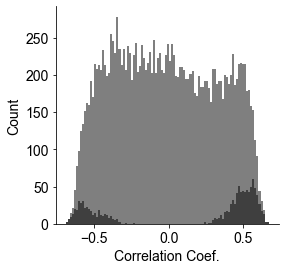

### Make and save out surrogate maps for raw and residual timescale maps
Can skip this cell if maps already exist in ../data/tau_nulls.csv

In [191]:
# tau surrogates 
n_maps = 1000
print('---- Making Surrogate for Raw Tau Maps ----')
gen = Base(df_tau['tau'].values, df_parcel_geo.values, resample=True)
tau_surrogates = gen(n=n_maps)
pd.DataFrame(tau_surrogates.T, index=df_tau.index.values).to_csv('../data/tau_nulls.csv')

print('---- Making Surrogate for PC1-Removed Tau Maps ----')
gen = Base(df_tau_rmvpc1['tau'].values, df_parcel_geo.values, resample=True)
tau_rmvpc1_surrogates = gen(n=n_maps)
pd.DataFrame(tau_rmvpc1_surrogates.T, index=df_tau.index.values).to_csv('../data/tau_nulls_rmvpc1.csv')

print('---- Making Surrogate for T1T2-Removed Tau Maps ----')
gen = Base(df_tau_rmvt1t2['tau'].values, df_parcel_geo.values, resample=True)
tau_rmvt1t2_surrogates = gen(n=n_maps)
pd.DataFrame(tau_rmvt1t2_surrogates.T, index=df_tau.index.values).to_csv('../data/tau_nulls_rmvt1t2.csv')

---- Making Surrogate for Raw Tau Maps ----
Generating 2000 maps...
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260


### Find gene associations
Possible methods:
- mass univariate pearson correlations/OLS
- mass univariate spearman
- partial least squares (PLS)

In [12]:
# load empirical and surrogate maps
print('Running Correlations on Tau Maps...')
map_emp = df_tau['tau'].values
map_surr = pd.read_csv('../data/tau_nulls.csv', header=0, index_col=0).values
df_tau_corr = echo_utils.run_emp_surrogate(map_emp, map_surr[:,:2], df_genes, '../data/tau_all_corr.csv')
print('-----')

Running Correlations on Tau Maps...
0|1|-----


In [13]:
print('Running Correlations on PC1-removed Tau Maps...')
map_emp = df_tau_rmvpc1['tau'].values
map_surr = pd.read_csv('../data/tau_nulls_rmvpc1.csv', header=0, index_col=0).values
df_tau_corr_rmvpc1 = run_emp_surrogate(map_emp, map_surr, df_gene_rmvpc1, '../data/tau_all_corr_rmvpc1.csv')
print('-----')

Running Correlations on PC1-removed Tau Maps...


FileNotFoundError: [Errno 2] File ../data/tau_nulls_rmvpc1.csv does not exist: '../data/tau_nulls_rmvpc1.csv'

In [ ]:
print('Running Correlations on T1T2-removed Tau Maps...')
map_emp = df_tau_rmvt1t2['tau'].values
map_surr = pd.read_csv('../data/tau_nulls_rmvt1t2.csv', header=0, index_col=0).values
df_tau_corr_rmvt1t2 = run_emp_surrogate(map_emp, map_surr, df_gene_rmvt1t2, '../data/tau_all_corr_rmvt1t2.csv')
print('-----')

Text(0, 0.5, 'Spearman Rho')

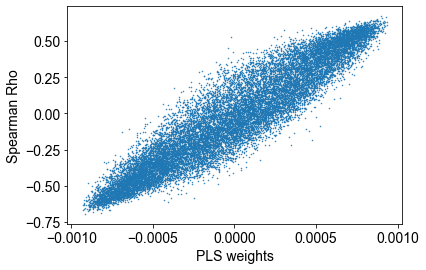

In [78]:
from sklearn.cross_decomposition import PLSRegression
pls = PLSRegression(n_components=1)
X = df_genes
Y = map_emp
pls.fit(X, Y)

#Y_pred = pls.predict(X)
plt.plot(pls.coef_.squeeze(), df_all_corr['rho'], '.', ms=1)
plt.xlabel('PLS weights'); plt.ylabel('Spearman Rho')

- load tau, gene, and myelin map
- make PC1 map
- make tau-residue map regressing out PC1 and myelin
- make surrogates for all the above
- save surrogates
- run gene correlation with surrogates
- GO analysis

### Generate Surrogate of Tau Maps

Generating 10 maps...
1
2
3
4
5
6
7
8
9
10


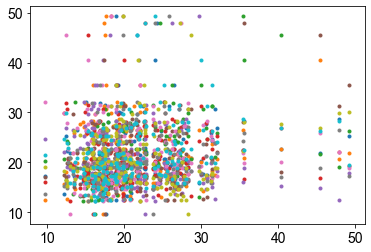

Generating 100 maps...
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100


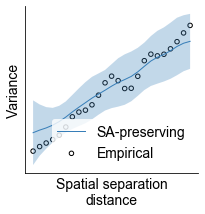

In [140]:
# base_fit(
#     x=df_tau['tau'].values,
#     D=d_parcel_geo.values,
#     nsurr=100,
#     nh=25,  # these are default kwargs, but shown here for demonstration
#     deltas=np.arange(0.1, 1, 0.1),
#     pv=25)  # kwargs are passed to brainsmash.mapgen.base.Base

base_fit(
    x=df_tau['tau'].values, # change units to ms because for whatever reason 
    D="../data/LeftParcelGeodesicDistmat.txt",
    nsurr=100,
    nh=25,  # these are default kwargs, but shown here for demonstration
    deltas=np.arange(0.1, 1, 0.1),
    pv=25,
    resample=True)  # kwargs are passed to brainsmash.mapgen.base.Base

---
# Gene Gradient Analysis (PCA)

In [4]:
y = df_tau['logtau']

# Perform PCA on gene matrix
n_pcs = 50
gene_pca = decomposition.PCA(n_pcs)
gene_pca.fit(np.array(df_genes))
df_gene_grad = pd.DataFrame(gene_pca.fit_transform(np.array(df_genes)), index = df_tau.index, columns = ['pc%i'%i for i in range(1,n_pcs+1)])
df_pc_weights = pd.DataFrame(gene_pca.components_.T, index=df_struct.columns[1:], columns=['pc%i'%i for i in range(1, n_pcs+1)])

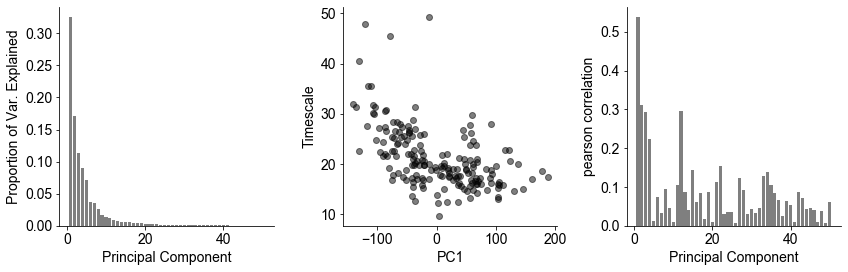

In [144]:
corr_method = 'pearson'
corr_tau_gpc = compute_all_corr(y, df_gene_grad, corr_method)

plt.figure(figsize=(12,4))

plt.subplot(1,3,1)
plt.bar(range(1,n_pcs+1), gene_pca.explained_variance_ratio_, fc='k', alpha=0.5)
plt.xlabel('Principal Component'); plt.ylabel('Proportion of Var. Explained'); despine();

plt.subplot(1,3,2)
plt.plot(df_gene_grad['pc1'], y, 'ko', alpha=0.5)
plt.xlabel('PC1'); plt.ylabel('Timescale'); despine();

plt.subplot(1,3,3)
plt.bar(range(1,n_pcs+1), np.abs(corr_tau_gpc['rho']), fc='k', alpha=0.5)
#plt.xticks([1, 10], ['1', '10']);
plt.xlabel('Principal Component'); plt.ylabel(corr_method+ ' correlation'); despine();
plt.tight_layout()

# Principal Component Regression & Sparse Regression
Predict timescale based on gene expression PCs and individual expression.

In [6]:
# using top_n principal components
X, y = df_gene_grad.iloc[:,:n_pcs], df_tau['logtau']
lm = linear_model.LinearRegression()
model = lm.fit(X, y)
print('R2 = %.4f'%lm.score(X, y))

R2 = 0.8177


In [7]:
# using all genes but with a Lasso regression (L1 & L2-penalized)
X, y = df_genes, df_tau['logtau']
lm = linear_model.ElasticNetCV(l1_ratio=0.)
model = lm.fit(X, y)
print('R2 = %.4f'%lm.score(X, y))

plt.figure(figsize=(15,4))
plt.plot(range(len(lm.coef_)),lm.coef_, 'ok', ms=3, alpha=0.2)
plt.xlabel('Gene');plt.ylabel('Coefficient');
despine(bottom=True)

ValueError: Automatic alpha grid generation is not supported for l1_ratio=0. Please supply a grid by providing your estimator with the appropriate `alphas=` argument.

---
# Individual Gene-Timescale Correlation

In [145]:
bon_alpha = 0.01/len(df_genes.columns)

In [146]:
df_taugene_corr = compute_all_corr(df_tau['tau'].values, df_genes, 'spearman')

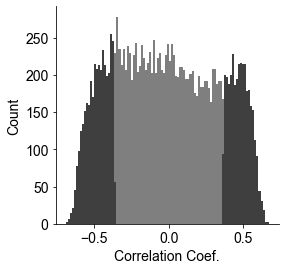

In [147]:
plot_print_genes(df_taugene_corr, bon_alpha, 'raw')

---
# Regressing out Gene PC1 from Timescale and Gene Expression Gradients
Find genes that are significantly correlated with timescale gradient after removing the dominant mode of gene expression variation (PC1).

In [18]:
# remove pc1 contribution from all genes
x = df_gene_grad['pc1'].values
df_gene_rmvpc1, gene_pc1_coeffs = get_residuals(x, df_genes)

# regress out PC1 from timescale features
df_tau_rmvpc1, _ = get_residuals(x, df_tau)
    
# compute correlation of timescale with individual genes
df_taugene_corr_pc1rmv = compute_all_corr(df_tau_rmvpc1['tau'].values, df_gene_rmvpc1, 'spearman')

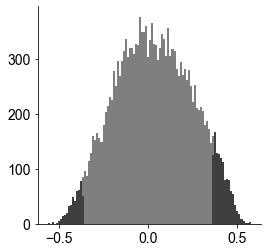

In [19]:
plot_print_genes(df_taugene_corr_pc1rmv, bon_alpha, 'pc1rmv')

---
# Regressing out T1w/T2w from Timescale and Gene Expression Gradient
Similar to above, but partialing out the contribution of anatomic gradient (myelination via T1w/T2w) from gene expression and timescale.

In [20]:
# remove T1/T2 contribution from all genes
x = df_struct['T1T2'].values
df_gene_rmvt1t2, gene_t1t2_coeffs = get_residuals(x, df_genes)

# regress out T1T2 from timescale features
df_tau_rmvt1t2, _ = get_residuals(x, df_tau)
    
# compute correlation of timescale with individual genes
df_taugene_corr_t1t2rmv = compute_all_corr(df_tau_rmvt1t2['tau'].values, df_gene_rmvt1t2, 'spearman')

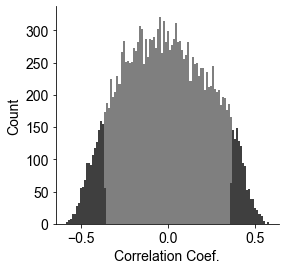

In [25]:
plot_print_genes(df_taugene_corr_t1t2rmv, bon_alpha, 't1t2rmv')

In [24]:
filename = '../data/go_lists/t1t2rmv/GO_results/t1t2rmv_all_bf_sig_cc.json'
with open(filename) as f:
    go_results = json.load(f)

print_GO(go_results)
#query_GO(go_results, 0,0)

------------------------------------
t1t2rmv_all_bf_sig.txt
GO cellular component complete
------------------------------------
0 0 FDR = 0.0374  | 12 enriched |   sodium channel complex
0 1 FDR = 0.0500  | 57 enriched |  > >  cation channel complex
0 2 FDR = 0.0321  | 70 enriched |  > > > >  ion channel complex
0 3 FDR = 0.0593  | 77 enriched |  > > > > > >  transmembrane transporter complex
0 4 FDR = 0.0503  | 77 enriched |  > > > > > > > >  transporter complex
0 5 FDR = 0.0339  | 797 enriched |  > > > > > > > > > >  intrinsic component of membrane
0 6 FDR = 0.0420  | 1298 enriched |  > > > > > > > > > > > >  membrane
___________
1 0 FDR = 0.0384  | 248 enriched |   neuron projection
1 1 FDR = 0.0297  | 371 enriched |  > >  plasma membrane bounded cell projection
1 2 FDR = 0.0343  | 385 enriched |  > > > >  cell projection
___________
2 0 FDR = 0.0358  | 268 enriched |   integral component of plasma membrane
2 1 FDR = 0.0311  | 279 enriched |  > >  intrinsic component of plasma membr